In [1]:
import requests
import json

import pandas as pd
import xarray as xr
import numpy as np
import glob as glob
import math

import matplotlib.pyplot as plt
import requests
import os
from datetime import datetime, timedelta
from scipy.interpolate import griddata


/Users/ramajem/Documents/mitgcm/mitgcm_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [27]:
#path where to save input files 
path_out = '/Users/ramajem/Documents/mitgcm/data/input_mitgcm/'


In [15]:
def write_binary(path_fname,data):
    '''
    Saves data in the right binary format for MITgcm, in the dimension order XYT
    Output binary files have been read and tested 
    '''

    data = data.to_numpy() #convert to xarray to numpy first - and then save to binary
    dtype = '>f8'  # big-endian and precision 64 (small-endian with precision 32 is '<f4')
    data = data.astype(dtype)

    # Write to file
    fid = open(path_fname, 'wb')
    data.tofile(fid)
    fid.close()



In [2]:

def interp_to_grid(json_file, data_type, lat_grid, lon_grid):
    '''
    json_file: path to json file
    data_type: string of parameter
    lat_grid, lon_grid: lat, lon mesh of grid for interpolation 
    '''
    
    with open(json_file, "r") as file:
        data = json.load(file)
        time = np.array(data).item().get('time')
        lat = np.array(data['lat'])
        lon = np.array(data['lng'])
        data = np.array(data[data_type]['data'])

    data_interp = []

    for ii in np.arange(len(time)):

        time_ii = time[ii]
        # Flatten the original lat/lon mesh and data
        coord_cosmo = np.array([lat.flatten(), lon.flatten()]).T
        data_flat = data[ii,:,:].flatten()
        data_interp_tt = griddata(coord_cosmo, data_flat, (lat_grid, lon_grid), method='cubic')

        # set as xarray - replace lat_grid and lon_grid with XY grid 
        data_interp_tt = xr.DataArray(data_interp_tt, dims=["Y", "X"], 
                                        coords={"X":x, "Y":y, })
        
        data_interp_tt = data_interp_tt.assign_coords({"T":time_ii})

        data_interp.append(data_interp_tt)

    data_interp = xr.concat(data_interp,dim='T').sortby('T')

    return (data_interp)



In [3]:
def interp_concat_json(json_files,data_type, lat_grid, lon_grid):
    
    all_data = []
    
    for file in json_files:
        data = interp_to_grid(file, data_type, lat_grid, lon_grid)
        all_data.append(data)

    all_data = xr.concat(all_data, dim='T').sortby('T')

    # remove duplicate values - review download from COSMO
    _, unique_ind = np.unique(np.unique(all_data['T'].values), return_index=True)
    unique_ind_sorted = np.sort(unique_ind)
    all_data = all_data.isel(T=unique_ind_sorted)

    # binary file for MITgcm should be in XYT
    all_data = all_data.transpose('X', 'Y', 'T')

    return (all_data)

In [4]:
path_grid = '/Users/ramajem/Documents/mitgcm/data/input_mitgcm/'
path_cosmo = '/Users/ramajem/Documents/mitgcm/data/input_raw/COSMO/'

### Load grid for MITgcm

In [5]:
x = np.load(path_grid + 'x.npy')
y = np.load(path_grid + 'y.npy')

lat_grid = np.load(path_grid + 'lat_grid.npy')
lon_grid = np.load(path_grid + 'lon_grid.npy')

### Load reanalysis data from COSMO

In [6]:
json_files = glob.glob(path_cosmo + '*.json')

with open(json_files[0], "r") as file:
    data = json.load(file)

data.keys()

dict_keys(['time', 'lat', 'lng', 'T_2M', 'U', 'V', 'GLOB', 'RELHUM_2M', 'PMSL', 'CLCT', 'PS', 'TOT_PREC'])

### Winds
- only interpolate onto model grid
- input for winds will be uwind and vwind; as opposed to ustress and vstress
- for formula for wind stress - check Wuest and Locke


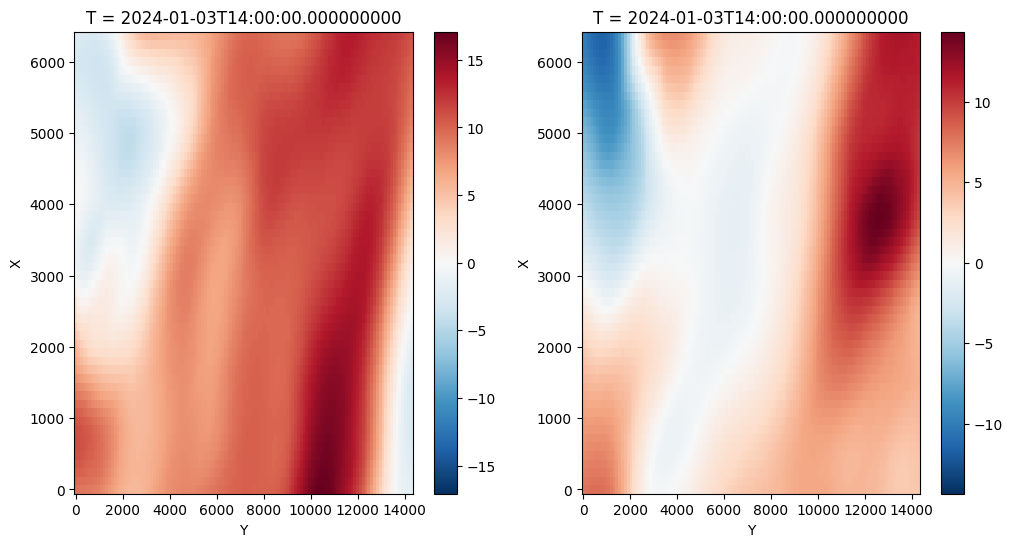

In [28]:
u10 = interp_concat_json(json_files,'U', lat_grid, lon_grid)
v10 = interp_concat_json(json_files,'V', lat_grid, lon_grid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
u10.isel(T=100).plot(ax=ax1)
v10.isel(T=100).plot(ax=ax2)



write_binary(path_out + 'u10.bin',u10)
write_binary(path_out + 'v10.bin',v10)




### Air temp (should be in kelvin)
- units already in K


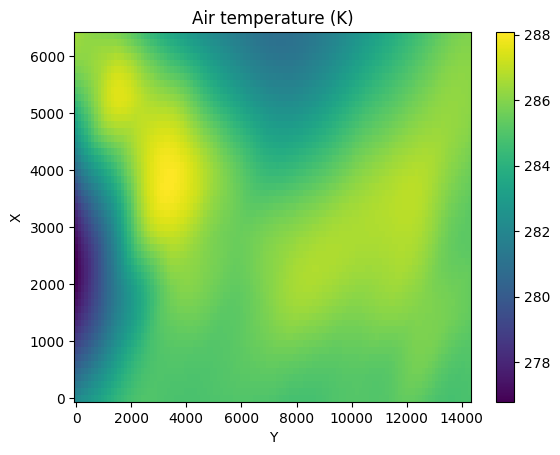

In [29]:
atemp = interp_concat_json(json_files,'T_2M', lat_grid, lon_grid)
atemp.isel(T=100).plot()
plt.title('Air temperature (K)')

write_binary(path_out + 'atemp.bin',atemp)


### Surface pressure (should be in Pa)
- units are N/m2, which is equivalent to Pa
- not sure if i should use pressure at mean sea level (and altitude height and temperature) to compute surface pressure 

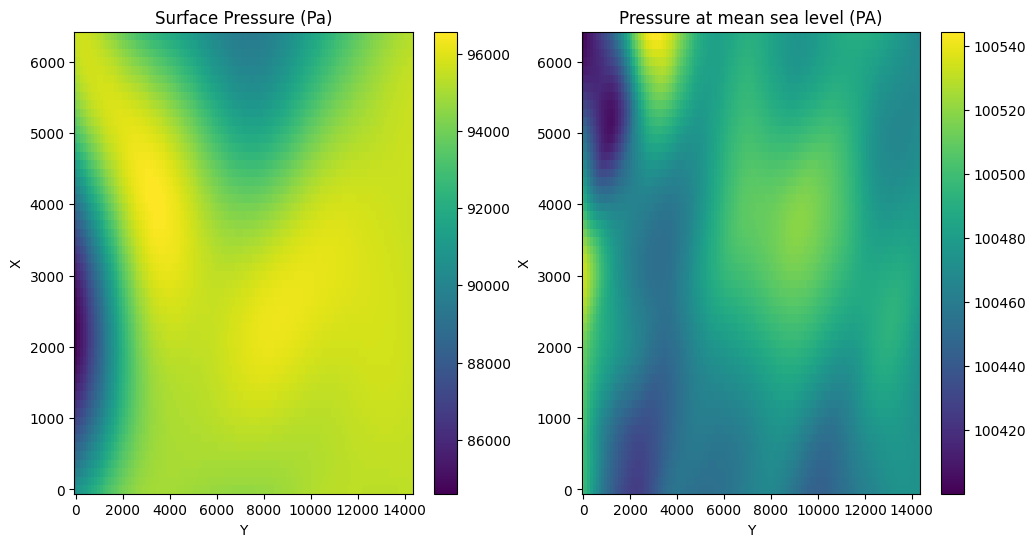

In [31]:
apress = interp_concat_json(json_files,'PS', lat_grid, lon_grid)
pmsl =  interp_concat_json(json_files,'PMSL', lat_grid, lon_grid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
apress.isel(T=100).plot(ax=ax1)
ax1.set_title('Surface Pressure (Pa)')

pmsl.isel(T=100).plot(ax=ax2)
ax2.set_title('Pressure at mean sea level (PA)')


write_binary(path_out + 'apressure.bin',apress)


### Surface specific humidity (should be in kg/kg)
- cosmo yields the relative humidity at 2m
- computes from temperature and relative humidity
- values seem too small - review formula 

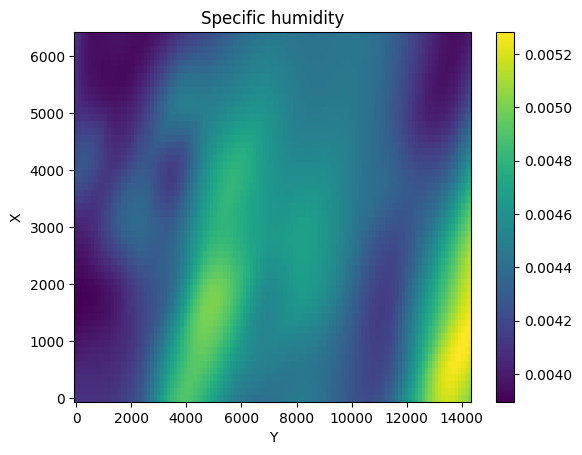

In [33]:
def calculate_specific_humidity(temp, relhum, atm_press):

    #temp needs to be in celcius
    temp = temp - 273.15
    
    # atmospheric pressure should be in hPa
    atm_press = atm_press / 100.0

    #saturation vapour pressure (e_s)
    e_s = 6.112 * np.exp((17.67 * temp) / (temp + 243.5))
    
    #actual vapour pressure (e)
    e = (relhum / 100) * e_s
    
    # Step 3: Calculate the specific humidity (q)
    q = (0.622 * e) / (atm_press - (0.378 * e))

    return (q)


relhum = interp_concat_json(json_files,'RELHUM_2M', lat_grid, lon_grid)
aqh = calculate_specific_humidity(atemp, relhum, apress)

aqh.isel(T=100).plot()
plt.title('Specific humidity')

write_binary(path_out + 'aqh.bin',aqh)
 

### Downward short wave radiation (should be in W/m2)

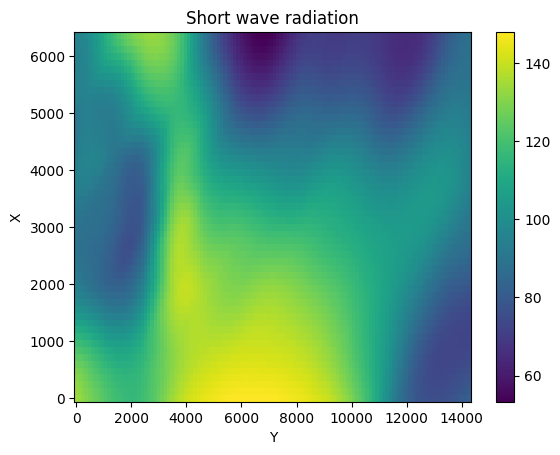

In [34]:
swr = interp_concat_json(json_files,'GLOB', lat_grid, lon_grid)
swr.isel(T=100).plot()
plt.title('Short wave radiation')

write_binary(path_out + 'swdown.bin',swr)


### Long wave radiation (in W/m2)
- computed from air temperature and cloud cover
- cloud cover is originally in % -  should range from 0 to 1  

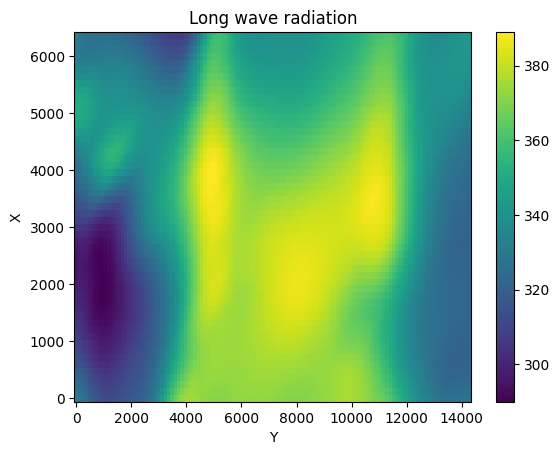

In [35]:
def compute_longwave_radiation(temp, cloud_cover):
    """
    Compute longwave radiation from air temperature and cloud cover.

    - temp: Air temperature in Kelvin 
    - cloud_cover: %
    """
    # cloud cover should be from 0 to 1 
    cloud_cover = cloud_cover/100
    cloud_cover = cloud_cover.where(cloud_cover > 0,0)
    vaporPressure = 6.11 * np.exp(17.67 * (atemp-273.15) / (atemp-29.65)) # in units of hPa
    A_L = 0.03   # Infrared radiation albedo
    a = 1.09     # Calibration parameter
    E_a = a * (1 + 0.17 * np.power(cloud_cover, 2)) * 1.24 * np.power(vaporPressure / atemp, 1./7)
    lwr = (1 - A_L) * 5.67e-8 * E_a * np.power(atemp, 4)
    return lwr

CLCT = interp_concat_json(json_files,'CLCT', lat_grid, lon_grid)
lwr = compute_longwave_radiation(atemp, CLCT)
lwr.isel(T=100).plot()
plt.title('Long wave radiation')

write_binary(path_out + 'lwdown.bin',lwr)

